Start time (YYYY-MM-DD):



 2022-01-01





End time (YYYY-MM-DD):



 2024-06-01



Showing range: 2022-01-01 - 2024-06-01

Total consumption over the period: 31820846.0 kWh

Total bill over the period: 3395855.4 €

Average hourly price: 11.83 cents

Average paid price: 10.67 cents



Select grouping interval (daily, weekly, monthly):  weekly


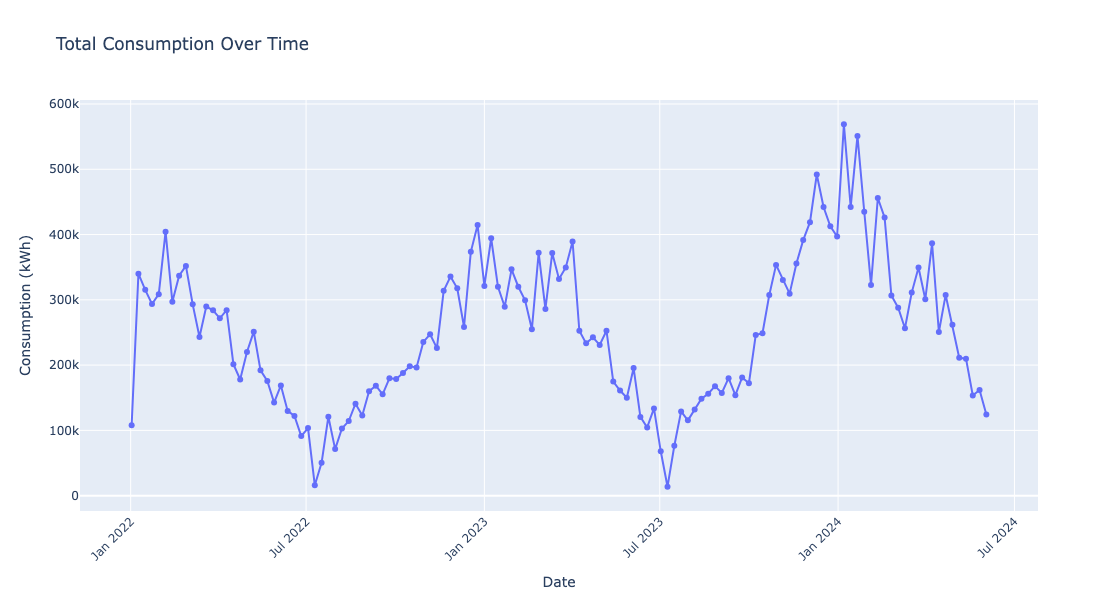

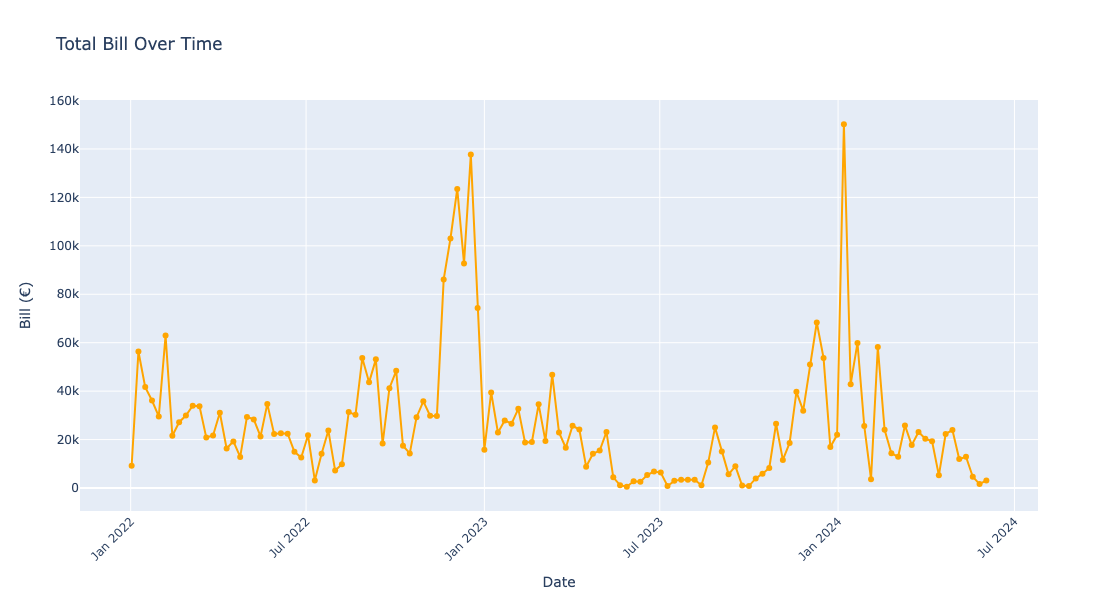

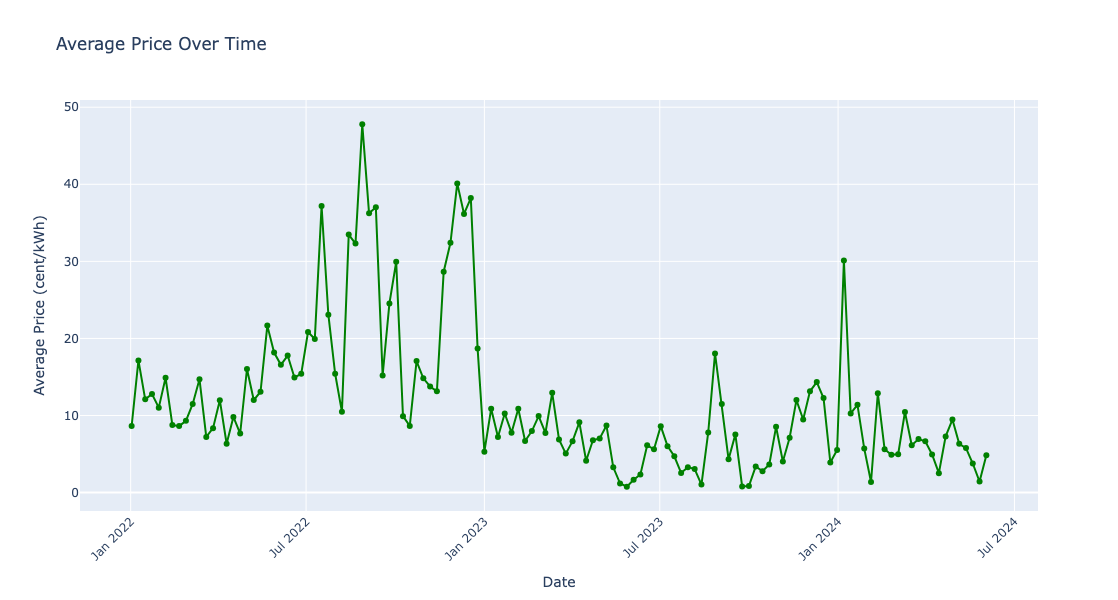

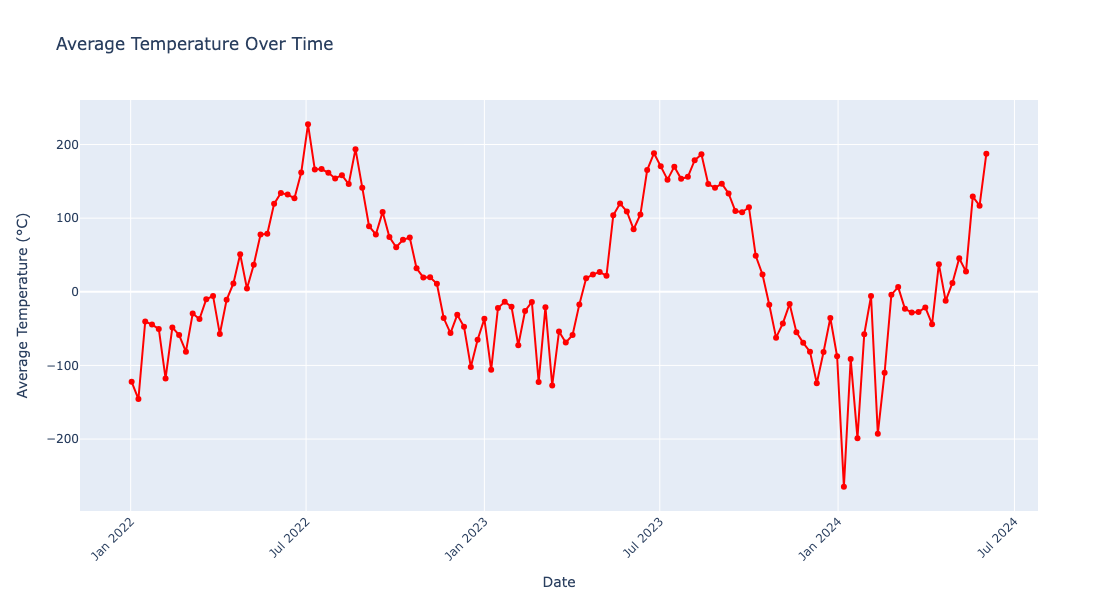

In [10]:
import pandas as pd
from datetime import datetime
import warnings
import matplotlib.pyplot as plt
import plotly.graph_objects as go
warnings.filterwarnings("ignore")

df1 = pd.read_csv('Electricity_20-09-2024.csv', delimiter = ';')
df2 = pd.read_csv('sahkon-hinta-010121-240924.csv')

# Step 1: Trim whitespace
df1['Time'] = df1['Time'].str.strip()
# Step 2: Convert to datetime format
df1['Time'] = pd.to_datetime(df1['Time'], format='%d.%m.%Y %H:%M', errors='coerce')
df1['Date'] = df1['Time'].dt.date
df1['Date'] = pd.to_datetime(df1['Date'], format='%Y-%m-%d', errors='coerce')
# Define the columns to convert
columns_to_convert = ['Energy (kWh)', 'Energy night(kWh)', 'Energy day (kWh)', 'Temperature']
# Loop through each column
for column in columns_to_convert:
    # Remove commas
    df1[column] = df1[column].str.replace(',', '', regex=False)
    
    # Convert to float, replacing NaNs with 0 if needed
    df1[column] = df1[column].astype(float)

# Fill null values in the Temperature column with 0
df1['Temperature'] = df1['Temperature'].fillna(0)

# Step 1: Trim whitespace
df2['Time'] = df2['Time'].str.strip()
# Step 2: Convert to datetime format
df2['Time'] = pd.to_datetime(df2['Time'], format='%d-%m-%Y %H:%M:%S', errors='coerce')
df2['Date'] = df2['Time'].dt.date
df2['Date'] = pd.to_datetime(df2['Date'], format='%Y-%m-%d', errors='coerce')

# Step 1: Join the DataFrames on 'Time'
merged_df = pd.merge(df1, df2, on='Time', how='inner')
# Step 2: Drop one of the Date columns
merged_df = merged_df.drop(columns=['Date_y'])  # Drop 'Date_y', keeping 'Date_x' or rename it
# Rename the remaining date column for clarity
merged_df.rename(columns={'Date_x': 'Date'}, inplace=True)
# Step 3: Calculate hourly bill paid
merged_df['Hourly Bill'] = merged_df['Energy (kWh)'] * (merged_df['Price (cent/kWh)'] / 100)

# Convert 'Date' column to datetime type
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

# Function to input date from the user (with validation)
def input_date(prompt):
    while True:
        try:
            print(prompt)  # Show the prompt
            print()  # Add a blank line after the prompt
            date_input = input()  # Input on the next line
            # Attempt to parse the input into a datetime object
            parsed_date = datetime.strptime(date_input, "%Y-%m-%d").date()
            return parsed_date
        except ValueError:
            print("Invalid date format. Please use YYYY-MM-DD.")

# Get start and end dates from the user using input_date function
start_date = input_date("Start time (YYYY-MM-DD):")
print("\n\n")  # Add two blank lines after start date input
end_date = input_date("End time (YYYY-MM-DD):")
# Convert dates to strings for comparison
start_date_str = start_date.strftime("%Y-%m-%d")
end_date_str = end_date.strftime("%Y-%m-%d")


# Filter the DataFrame based on the selected dates
filtered_df = merged_df[(merged_df['Date'] >= start_date_str) & (merged_df['Date'] <= end_date_str)]
# Calculate total consumption, total bill, average hourly price, and average paid price
total_consumption = filtered_df['Energy (kWh)'].sum()
total_bill = filtered_df['Hourly Bill'].sum()
average_hourly_price = filtered_df['Price (cent/kWh)'].mean()
average_paid_price = filtered_df['Hourly Bill'].sum() / filtered_df['Energy (kWh)'].sum() * 100  # Average paid price in cents
# Display the results
print(f"\nShowing range: {start_date_str} - {end_date_str}\n")
print(f"Total consumption over the period: {total_consumption:.1f} kWh\n")
print(f"Total bill over the period: {total_bill:.1f} €\n")
print(f"Average hourly price: {average_hourly_price:.2f} cents\n")
print(f"Average paid price: {average_paid_price:.2f} cents\n")


# Assuming `filtered_df` is your DataFrame with the filtered data.

# Ensure 'Date' is in datetime format
filtered_df['Date'] = pd.to_datetime(filtered_df['Date'])

# Step 1: Input for grouping interval
grouping_interval = input("Select grouping interval (daily, weekly, monthly): ").strip().lower()

# Step 2: Calculate metrics based on the selected interval
if grouping_interval == 'daily':
    # Group by date
    summary = filtered_df.groupby('Date').agg(
        Daily_Consumption=('Energy (kWh)', 'sum'),
        Daily_Bill=('Hourly Bill', 'sum'),
        Average_Price=('Price (cent/kWh)', 'mean'),
        Average_Temperature=('Temperature', 'mean')
    ).reset_index()

elif grouping_interval == 'weekly':
    # Group by week
    summary = filtered_df.resample('W', on='Date').agg(
        Weekly_Consumption=('Energy (kWh)', 'sum'),
        Weekly_Bill=('Hourly Bill', 'sum'),
        Average_Price=('Price (cent/kWh)', 'mean'),
        Average_Temperature=('Temperature', 'mean')
    ).reset_index()

elif grouping_interval == 'monthly':
    # Group by month
    summary = filtered_df.resample('M', on='Date').agg(
        Monthly_Consumption=('Energy (kWh)', 'sum'),
        Monthly_Bill=('Hourly Bill', 'sum'),
        Average_Price=('Price (cent/kWh)', 'mean'),
        Average_Temperature=('Temperature', 'mean')
    ).reset_index()

else:
    print("Invalid grouping interval selected.")
    summary = pd.DataFrame()  # Empty DataFrame if invalid input

# Step 3: Calculate total metrics
if not summary.empty:
    total_consumption = summary['Daily_Consumption'].sum() if grouping_interval == 'daily' else \
                        summary['Weekly_Consumption'].sum() if grouping_interval == 'weekly' else \
                        summary['Monthly_Consumption'].sum()

    total_bill = summary['Daily_Bill'].sum() if grouping_interval == 'daily' else \
                 summary['Weekly_Bill'].sum() if grouping_interval == 'weekly' else \
                 summary['Monthly_Bill'].sum()

    average_price = summary['Average_Price'].mean() if grouping_interval == 'daily' else \
                    summary['Average_Price'].mean() if grouping_interval == 'weekly' else \
                    summary['Average_Price'].mean()

    average_temperature = summary['Average_Temperature'].mean() if grouping_interval == 'daily' else \
                         summary['Average_Temperature'].mean() if grouping_interval == 'weekly' else \
                         summary['Average_Temperature'].mean()

    # Step 4: Visualization of individual metrics using Plotly

    # Set figure size
    chart_width = 1200
    chart_height = 600

    # Consumption plot
    fig1 = go.Figure()
    fig1.add_trace(go.Scatter(x=summary['Date'], 
                               y=summary['Daily_Consumption'] if grouping_interval == 'daily' else 
                                 summary['Weekly_Consumption'] if grouping_interval == 'weekly' else 
                                 summary['Monthly_Consumption'],
                               mode='lines+markers',
                               name='Consumption (kWh)'))
    fig1.update_layout(title='Total Consumption Over Time',
                       xaxis_title='Date',
                       yaxis_title='Consumption (kWh)',
                       xaxis_tickangle=-45,
                       width=chart_width,
                       height=chart_height)
    fig1.show()

    # Bill plot
    fig2 = go.Figure()
    fig2.add_trace(go.Scatter(x=summary['Date'], 
                               y=summary['Daily_Bill'] if grouping_interval == 'daily' else 
                                 summary['Weekly_Bill'] if grouping_interval == 'weekly' else 
                                 summary['Monthly_Bill'],
                               mode='lines+markers',
                               name='Bill (€)', line=dict(color='orange')))
    fig2.update_layout(title='Total Bill Over Time',
                       xaxis_title='Date',
                       yaxis_title='Bill (€)',
                       xaxis_tickangle=-45,
                       width=chart_width,
                       height=chart_height)
    fig2.show()

    # Average Price plot
    fig3 = go.Figure()
    fig3.add_trace(go.Scatter(x=summary['Date'], 
                               y=summary['Average_Price'],
                               mode='lines+markers',
                               name='Average Price (cent/kWh)', line=dict(color='green')))
    fig3.update_layout(title='Average Price Over Time',
                       xaxis_title='Date',
                       yaxis_title='Average Price (cent/kWh)',
                       xaxis_tickangle=-45,
                       width=chart_width,
                       height=chart_height)
    fig3.show()

    # Average Temperature plot
    fig4 = go.Figure()
    fig4.add_trace(go.Scatter(x=summary['Date'], 
                               y=summary['Average_Temperature'],
                               mode='lines+markers',
                               name='Average Temperature (°C)', line=dict(color='red')))
    fig4.update_layout(title='Average Temperature Over Time',
                       xaxis_title='Date',
                       yaxis_title='Average Temperature (°C)',
                       xaxis_tickangle=-45,
                       width=chart_width,
                       height=chart_height)
    fig4.show()

else:
    print("No data available for the selected grouping interval.")

